# Data Science Essentials: GeoPandas
    Jane Slagle
    Vol 3 lab BOOyuh
    9/28/22

In [ ]:
import geopandas as gpd
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from shapely.geometry import Point, Polygon
from matplotlib.colors import LogNorm
from matplotlib.cm import ScalarMappable
from matplotlib import animation
from IPython.display import HTML
%matplotlib inline

## Problem 1

Read in the file *airports.csv* as a pandas dataframe.
Create three convex hulls around the three sets of airports listed below.
This can be done by passing in lists of the airports' coordinates to a *shapely.geometry.Polygon* object.

1. Maio Airport, Scatsta Airport, Stokmarknes Skagen Airport, Bekily Airport, K. D. Matanzima Airport, RAF Ascension Island
2. Oiapoque Airport, Maio Airport, Zhezkazgan Airport, Walton Airport, RAF Ascension Island, Usiminas Airport, Piloto Osvaldo Marques Dias Airport
3. Zhezkazgan Airport, Khanty Mansiysk Airport, Novy Urengoy Airport, Kalay Airport, Biju Patnaik Airport, Walton Airport
	
Create a new GeoDataFrame with these three Polygons as entries.
Plot this GeoDataFrame on top of an outlined world map.

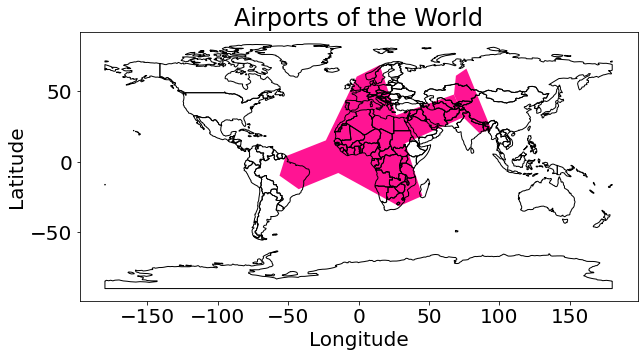

In [145]:
first_set = ['Maio Airport', 'Scatsta Airport', 'Stokmarknes Skagen Airport',
                 'Bekily Airport','K. D. Matanzima Airport', 'RAF Ascension Island']
second_set = ['Oiapoque Airport','Maio Airport', 'Zhezkazgan Airport',
                'Walton Airport','RAF Ascension Island','Usiminas Airport',
                 'Piloto Osvaldo Marques Dias Airport']
third_set = ['Zhezkazgan Airport','Khanty Mansiysk Airport','Novy Urengoy Airport',
                 'Kalay Airport','Biju Patnaik Airport','Walton Airport']

airports = pd.read_csv("airports.csv", index_col = 'Name') #read in airports.csv file as pandas dataframe

airports['Coordinates'] = list(zip(airports.Longitude, airports.Latitude)) #create geometry column (need to make GeoDataFrame)
airports['Coordinates'] = airports['Coordinates'].apply(Point)             #make geometry column shapely objects
airports = gpd.GeoDataFrame(airports, geometry='Coordinates')              #cast it as GeoDataFrame now

#now pass list of coords for each of 3 airport sets into Polygon object and Polygon makes it convex hull
poly1 = Polygon(airports.loc[first_set, 'Coordinates'])
poly2 = Polygon(airports.loc[second_set, 'Coordinates'])
poly3 = Polygon(airports.loc[third_set, 'Coordinates'])

#create new GeoDataFrame w/ 3 Polygons as entries:
airport_tings = gpd.GeoDataFrame({'geometry':[poly1, poly2, poly3]})

#plot the polygons on top of outlined world map:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
fig,ax = plt.subplots(figsize=(10,7), ncols=1, nrows=1)
base = world.boundary.plot(edgecolor='black', ax=ax, linewidth=1) #get outline of world countries as base

airport_tings.plot(ax=base, marker='o', color='deeppink', markersize=1)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
ax.set_title("Airports of the World")
plt.show()

## Problem 2
Use the command *geopandas.read_file('county_data.gpkg')* to create a GeoDataFrame of information about US counties.
Each county's shape is stored in the *geometry* column.
Use this to **plot the outlines of all US counties two times**, first using the default CRS and then using EPSG:5071.

Next, create a new GeoDataFrame that combines all counties within a single state.
Drop states with the following STATEFP codes: 02, 15, 60, 66, 69, 72, 78.
Plot this GeoDataFrame to see an outline of the 48 contiguous states.
Ensure a CRS of 5071.

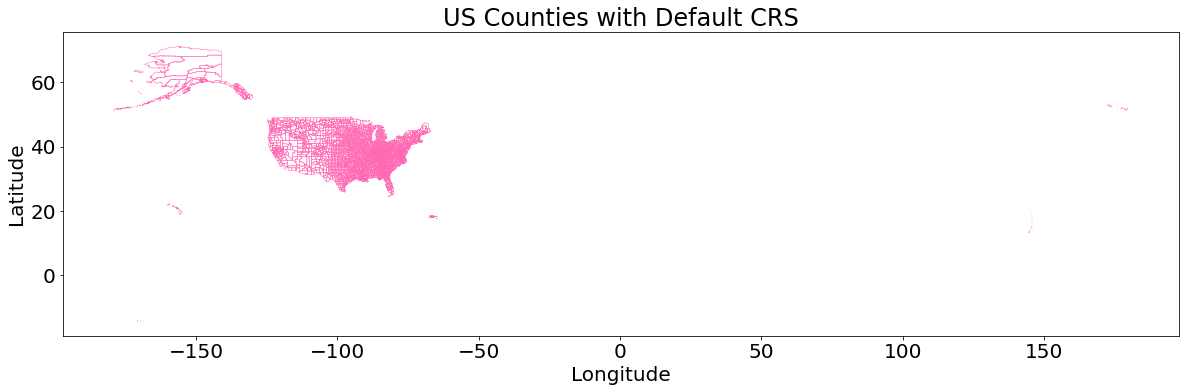

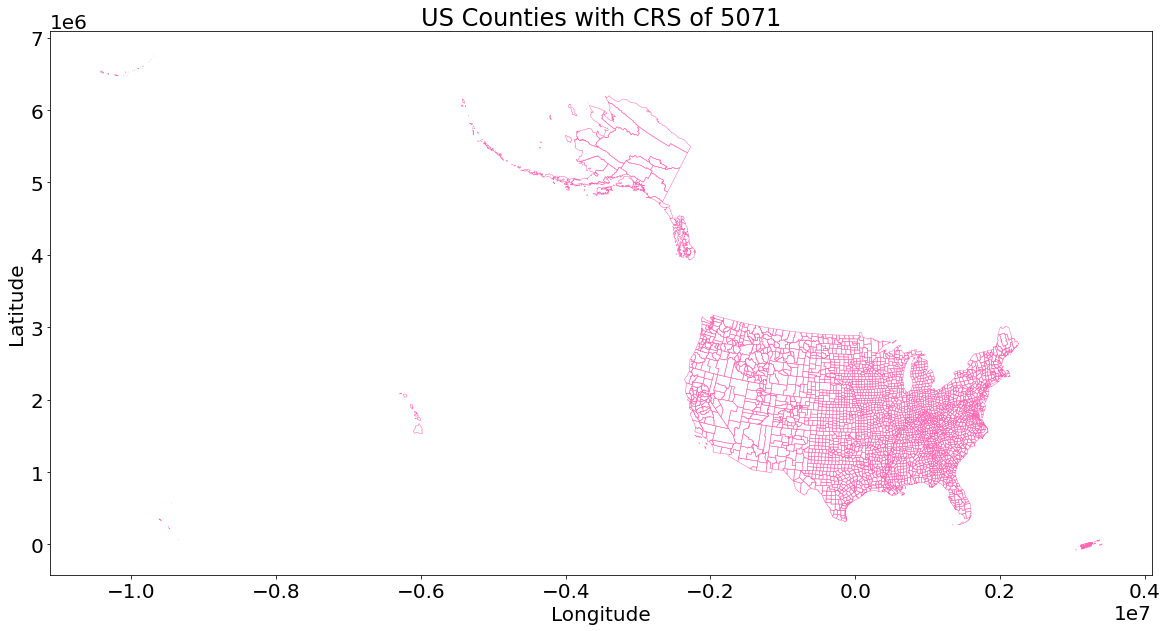

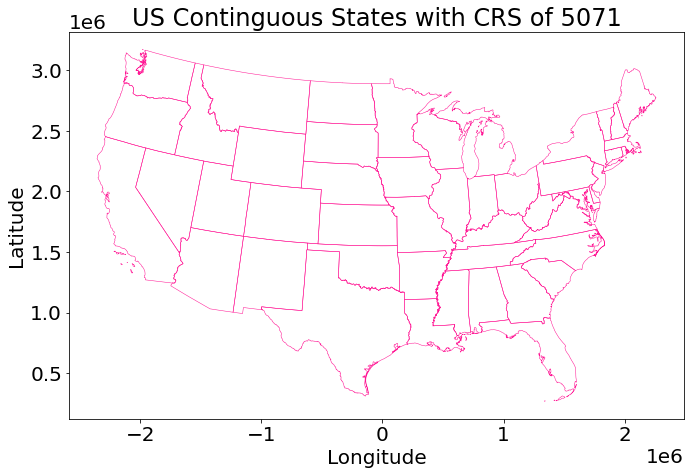

In [146]:
county_data = gpd.read_file('county_data.gpkg') #create GeoDataFrame of info in this file

#make the plot bigger:
plt.rcParams.update({'font.size': 20})
plt.rcParams["figure.figsize"] = (20, 10)

#plot US counties for default CRS:
county_data.boundary.plot(linewidth = 0.5, color = "hotpink") #will automatically plot geometry column since it's a GeoDataFrame
plt.title("US Counties with Default CRS")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

county_data.to_crs(5071, inplace=True) #change the default CRS to be 5071
county_data.boundary.plot(linewidth = 0.5, color = "hotpink") #plot US counties for non-default CRS
plt.title("US Counties with CRS of 5071")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

#use mask to drop states w/ given STATEFP codes:
mask = ~county_data['STATEFP'].isin(['02', '15', '60', '66', '69', '72', '78']) #find states w/ those STATEFP values
                                                                                #and then have ~ to say get all
                                                                                #states except those ones
new_states = county_data[mask] #now actually drop the states via the mask
states = new_states.dissolve(by = 'STATEFP') #now create new GeoDataFrame that combines all counties w/in single state

#plot the new GeoDataFrame w/ CRS of 5071
fig, ax = plt.subplots(figsize = (10, 7), ncols = 1, nrows = 1)
base = states.to_crs(5071).boundary.plot(edgecolor = "deeppink", ax = ax, linewidth = 0.5)
ax.plot(ax = base)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_title("US Continguous States with CRS of 5071")
plt.tight_layout()
plt.show()

## Problem 3

Load in the file *nytimes.csv* as a DataFrame.
This file includes county-level data for the cumulative cases and deaths of Covid-19 in the US, starting with the first case in Snohomish County, Washington, on January 21, 2020.
**First, convert the *date* column into a *DatetimeIndex*.**

Next, use county FIPS codes to **merge your GeoDataFrame from the previous problem with the DataFrame you just created.**
A FIPS code is a 5-digit unique identifier for geographic locations.
For this lab, we will not use rows in the Covid-19 DataFrame with unknown FIPS codes.
Also, we will just be examining data from the contiguous US, so **drop all data from Hawaii and Alaska and rows with unknown FIPS codes.**

Note that the *fips* column of the Covid-19 DataFrame stores entries as floats, but the county GeoDataFrame stores FIPS codes as strings, with the first two digits in the *STATEFP* column and the last three in the *COUNTYFP* column.

**Plot the cases from March 21, 2020 on top of your state outline map from the previous problem.
Finally, print out the name of the county with the most cases on March 21, 2020 along with its case count.**

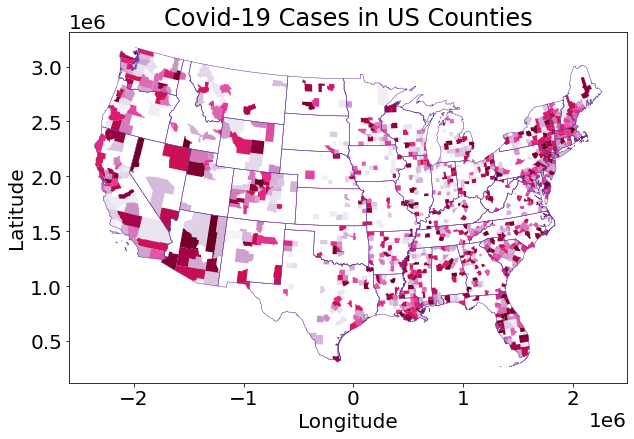

New York City


In [147]:
nytimes_df = pd.read_csv("nytimes.csv") #load in file as DataFrame
nytimes_df['date'] = pd.to_datetime(nytimes_df['date']) #convert date column into a Datetimeindex

#get the FIPS codes from county_data dataframe from prob 2. need change to be float to match data from nytimes df
county_data['fips'] = (county_data['STATEFP'] + county_data['COUNTYFP']).astype(float)

#need to REmake same dataframe as prob 2, so need to drop all of the same ones still, have remake bc have new fips column now from prob 2
mask = ~county_data['STATEFP'].isin(['02', '15', '60', '66', '69', '72', '78']) #drops Hawaii, Alaska
new_states = county_data[mask] #now have dataframe from prob 2 that want now

covid_df = new_states.merge(nytimes_df, on = 'fips') #merge GeoDataFrame from prob 2 w/ dataframe just made using FIPS code

#plot on top of state outline map from previous problem
fig, ax = plt.subplots(figsize = (10, 7), ncols = 1, nrows = 1)
base = states.to_crs(5071).boundary.plot(edgecolor = "rebeccapurple", ax = ax, linewidth = 0.5)

#plot covid cases from March 21, 2020 on top of plot from last problem
day = covid_df.loc[covid_df["date"] == "2020-03-21"].set_index('county') #1st need get the cases from the date want
                                                                         #county index is the name of the county
day.plot(ax=base, cmap = "PuRd") 
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Covid-19 Cases in US Counties")
plt.show()

#print out name of county w/ most cases on day along its case count
index = day['cases'].idxmax() #get index of county w/ most cases on day we want
print(index)

## Problem 4

As in Problem 3, plot your state outline map together with a map of Covid-19 cases from March 21, 2020.
This time, use a log scale.
Use EPSG:5071.
Pick a good colormap and be sure to display a colorbar.

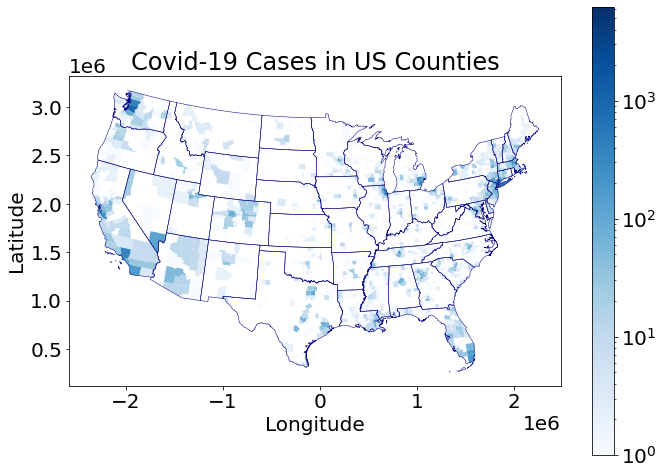

In [148]:
#use all info and variables from prob 3:

#set the norm using data bounds: data here is the cases from day want bc that's what want to plot
data = day['cases']
norm = LogNorm(vmin = min(data), vmax = max(data))

#plot on top of state outline map from previous problem:
fig, ax = plt.subplots(figsize = (10, 7), ncols = 1, nrows = 1)
base = states.to_crs(5071).boundary.plot(edgecolor = "navy", ax = ax, linewidth = 0.5)

#plot covid cases from date on top of previous plot w/ CSR 5071
day.to_crs(5071).plot(column = 'cases', cmap = "Blues", ax = base, legend = True, norm = norm)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Covid-19 Cases in US Counties")
plt.tight_layout()
plt.show()

## Problem 5
In this problem, you will create an animation of the spread of Covid-19 through US counties from January 21, 2020 to June 21, 2020.
Use a log scale and a good colormap, and be sure that you're using the same norm and colorbar for the whole animation.
Use EPSG:5071 for the CRS.

As a reminder, below is a summary of what you will need in order to animate this map.
You may also find it helpful to refer to the animation section included with the Volume 4 lab manual. 

- Set up your figure and norm. Be sure to use the highest case count for your vmax so that the scale remains uniform.
- Write your update function. This should plot the cases from a given day.
- Set up your colorbar. Do this outside the update function to avoid adding a new colorbar each day.
- Create the animation and embed it.

In [151]:
#Set up figure and norm:
#first set up figure:
fig, ax = plt.subplots(figsize = (10, 7), ncols = 1, nrows = 1)
base = states.to_crs(5071).boundary.plot(edgecolor = "navy", ax = ax, linewidth = 0.5)

#now set up the norm:
data = covid_df['cases'] #data will be ALL cases bc want overall spread, so is cases across all the data
norm = LogNorm(vmin = min(data), vmax = max(data))

#set x, y labels before plot for each day:
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

def update(date):
    ax.set_title("Spread of Covid-19 Cases in the US by County on " + str(date))
    #Plot the cases from a single day:
    mask = covid_df['date'] == date   #use mask to get single day want
    single_day = covid_df[mask]       #now get the actual single day
    
    plt.tight_layout()
    single_day.to_crs(5071).plot(column = 'cases', cmap = "Blues", ax = base, norm = norm)
    plt.close()
    
#Set up the colorbar:
cbar = fig.colorbar(ScalarMappable(norm=norm, cmap='Blues'),
        ax=ax, orientation='vertical', pad=0, label='Covid-19 Cases')

#create the range of dates that want animation over:
dates = pd.date_range(start=min(covid_df['date']), end=max(covid_df['date']))

#Create and embed the animation:
ani = animation.FuncAnimation(fig, update, frames=dates, interval=100)
ani.save("prob_5_covid_animation.mp4")

plt.show()

In [152]:
#dipslay the video from the file now
HTML('<video src="prob5_animation.mp4" controls>')